<a href="https://colab.research.google.com/github/KDcommits/LLM-LangChain-GenAI-VctorDB/blob/master/Query_SQL_Database_with_LLAMA2_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Query SQL database with LLAMA2 7B </h1>

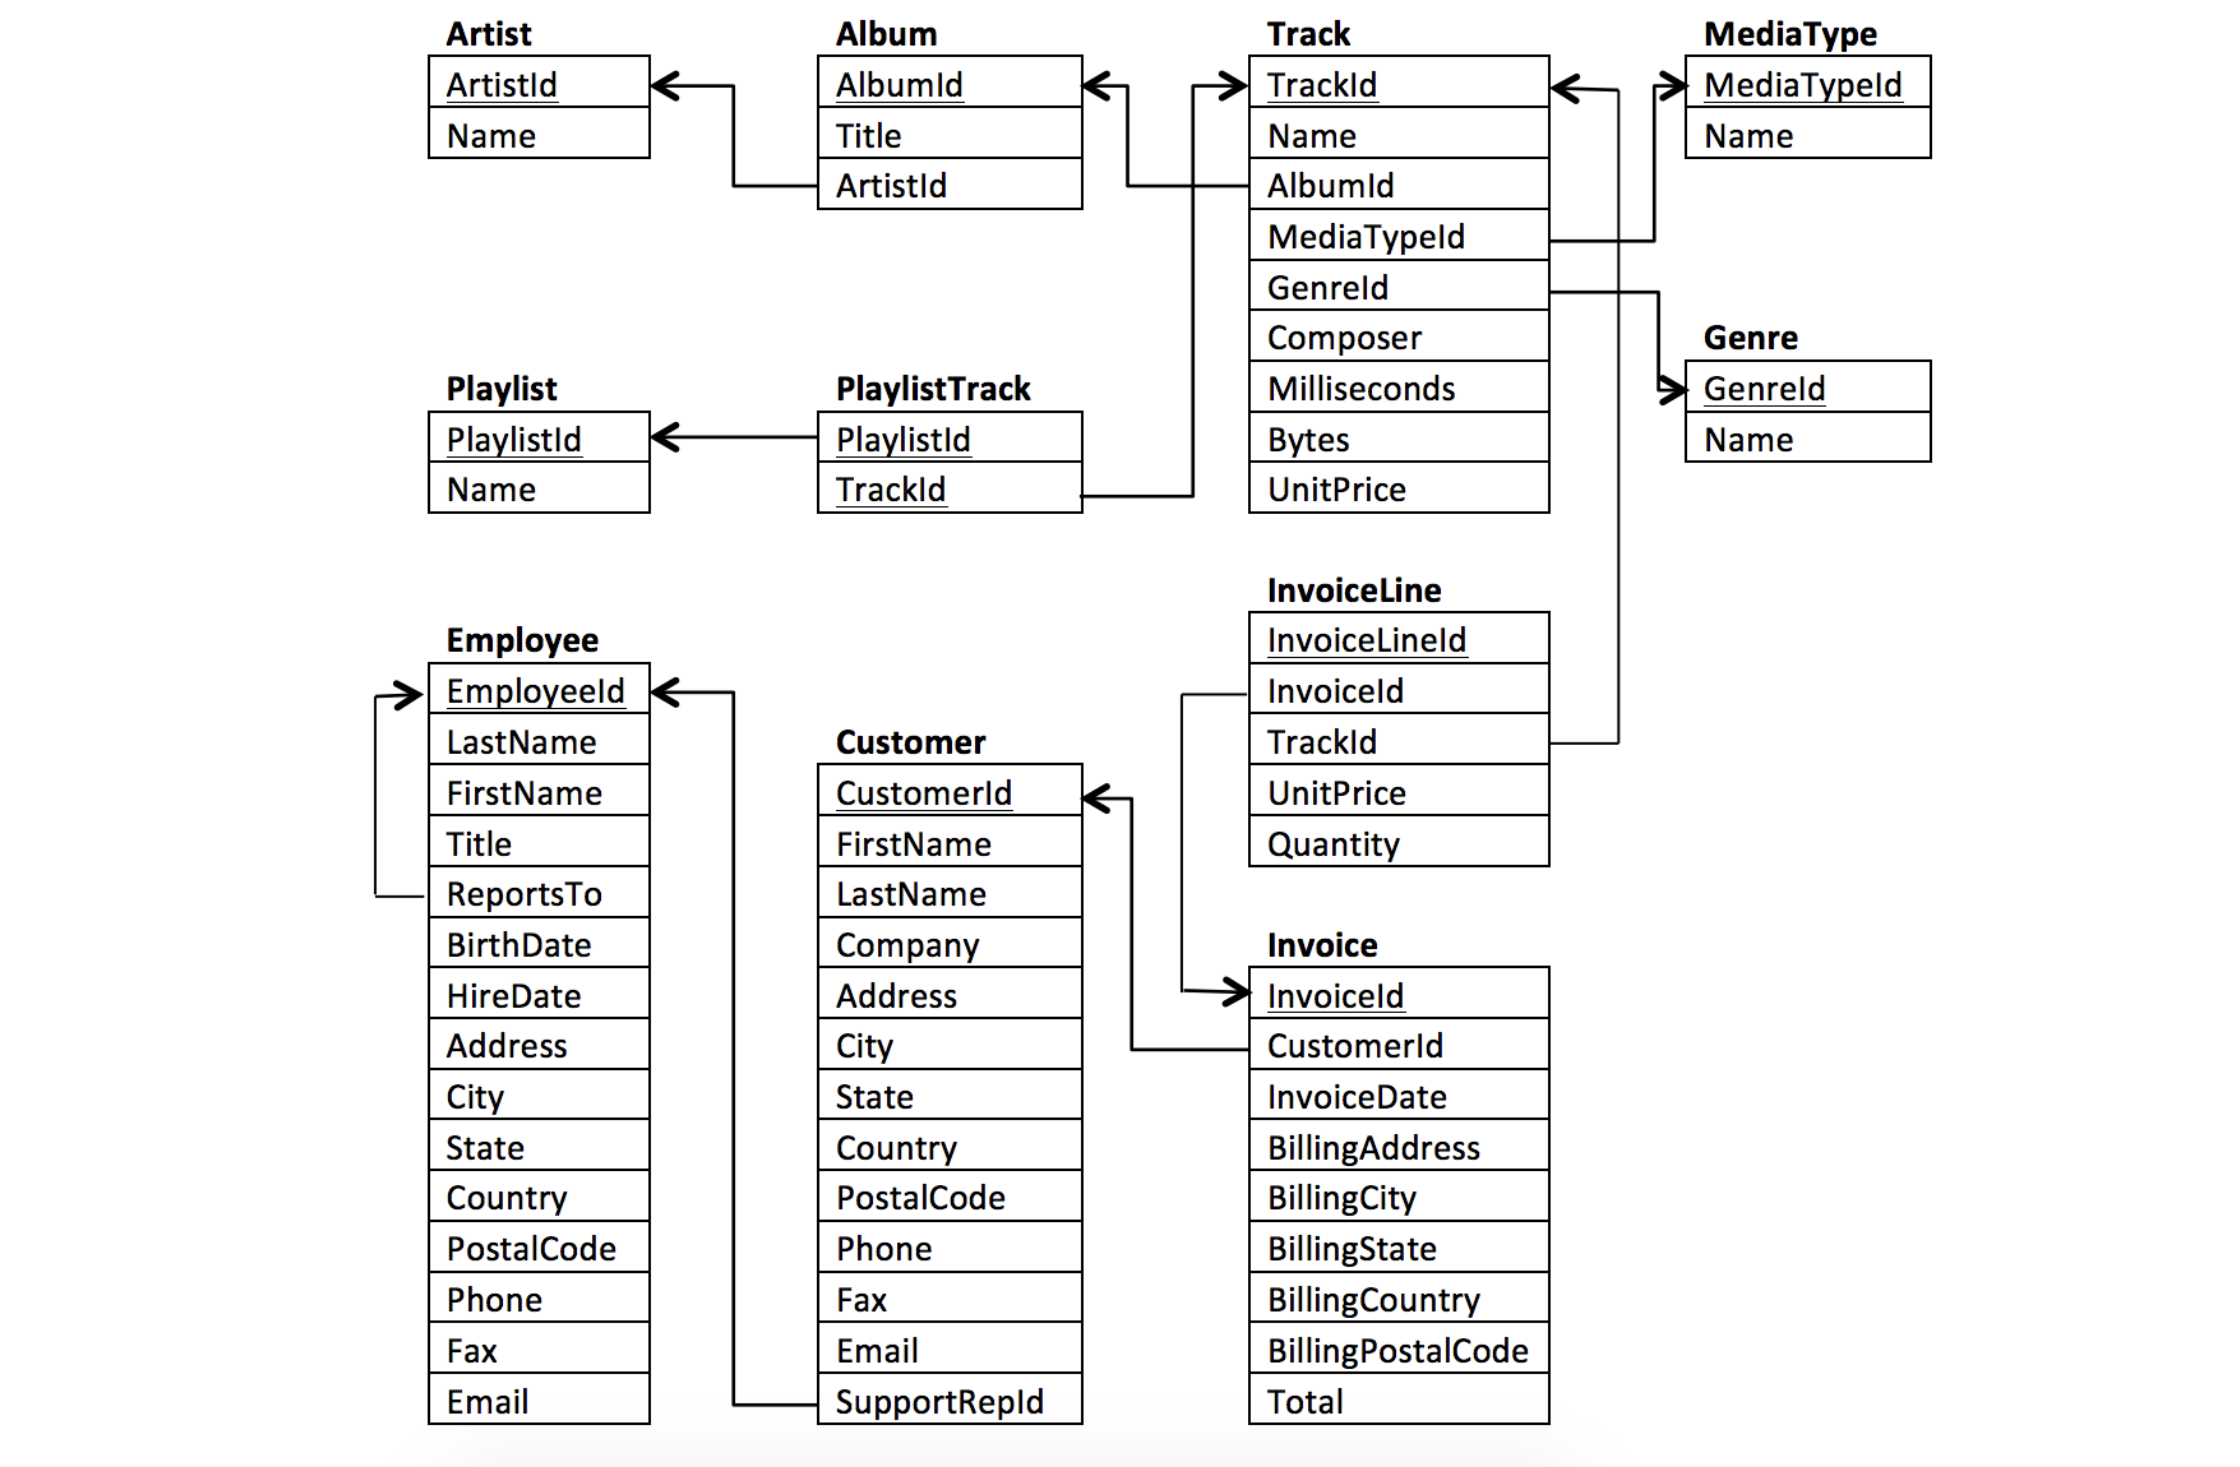

## STEP 1 : Installations & Imports

In [1]:
!pip -q install git+https://github.com/huggingface/transformers
!pip -q install langchain
!pip -q install accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.8 MB/s eta 0:00:00


In [2]:
import re
import sqlite3
import transformers
import pandas as pd
from transformers import pipeline
from langchain import HuggingFacePipeline
from langchain.memory import ConversationBufferMemory
from langchain import LLMChain, PromptTemplate
from langchain import PromptTemplate,  LLMChain
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import notebook_login

## STEP 2 : Load the model

In [3]:
## authenticate with huggingface token
notebook_login()

In [4]:
## laod the model and the tokenizer in float16 format
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf",
                                          use_auth_token=True,)

model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf",
                                             device_map='auto',
                                             torch_dtype=torch.float16,
                                             use_auth_token=True,
                                            #  load_in_8bit=True,
                                            #  load_in_4bit=True
                                             )

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:702: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

## STEP 3 : Create Text Generation pipeline

In [5]:
def create_pipeline(model, tokenizer):
    '''
        Creation of a text generation pipeline
    '''
    pipe = pipeline("text-generation",
                    model=model,
                    tokenizer= tokenizer,
                    torch_dtype=torch.bfloat16,
                    device_map="auto",
                    max_new_tokens = 512,
                    do_sample=True,
                    top_k=30,
                    num_return_sequences=1,
                    eos_token_id=tokenizer.eos_token_id
                    )
    hf_pipe = HuggingFacePipeline(pipeline = pipe, model_kwargs = {'temperature':0})

    return hf_pipe

## STEP 4 : Fetch the database schema info

- LLAMA2 System Prompt:
    - https://medium.com/@eboraks/llama-2-prompt-engineering-extracting-information-from-articles-examples-45158ff9bd23
    - https://huggingface.co/blog/llama2

In [47]:
def fetch_db_schema(db_path):
    connection = sqlite3.connect(db_path)
    cursor = connection.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_names = cursor.fetchall()
    schema_info = ""
    column_items =[]
    for table_name in table_names:
        column_item = []
        schema_info += f"table: {table_name[0]},"
        schema_info += f"columns: "
        cursor.execute(f"PRAGMA table_info({table_name[0]});")
        columns_info = cursor.fetchall()
        for i in columns_info:
            column_name = i[1]
            column_dtype =  i[2]
            column_item.append(column_name+" "+ column_dtype)
        schema_info+= ",".join(column_item)+'\n'

    connection.close()
    return schema_info

db_path = '/content/chinook.db'
db_schema = fetch_db_schema(db_path=db_path)
print(db_schema)


table: albums,columns: AlbumId INTEGER,Title NVARCHAR(160),ArtistId INTEGER
table: sqlite_sequence,columns: name ,seq 
table: artists,columns: ArtistId INTEGER,Name NVARCHAR(120)
table: customers,columns: CustomerId INTEGER,FirstName NVARCHAR(40),LastName NVARCHAR(20),Company NVARCHAR(80),Address NVARCHAR(70),City NVARCHAR(40),State NVARCHAR(40),Country NVARCHAR(40),PostalCode NVARCHAR(10),Phone NVARCHAR(24),Fax NVARCHAR(24),Email NVARCHAR(60),SupportRepId INTEGER
table: employees,columns: EmployeeId INTEGER,LastName NVARCHAR(20),FirstName NVARCHAR(20),Title NVARCHAR(30),ReportsTo INTEGER,BirthDate DATETIME,HireDate DATETIME,Address NVARCHAR(70),City NVARCHAR(40),State NVARCHAR(40),Country NVARCHAR(40),PostalCode NVARCHAR(10),Phone NVARCHAR(24),Fax NVARCHAR(24),Email NVARCHAR(60)
table: genres,columns: GenreId INTEGER,Name NVARCHAR(120)
table: invoices,columns: InvoiceId INTEGER,CustomerId INTEGER,InvoiceDate DATETIME,BillingAddress NVARCHAR(70),BillingCity NVARCHAR(40),BillingState NV

## STEP 5: Create Prompt

In [48]:
def create_prompt_structure(instruction, system_prompt):
    B_INST, E_INST = "[INST]", "[/INST]"
    B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
    SYSTEM_PROMPT = B_SYS + system_prompt + E_SYS
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    return prompt_template

def create_prompt(db_schema_info):
    instruction = "Chat History:\n\n{chat_history} \n\nUser: {user_input}"
    system_prompt = f"""\
    You are a helpful SQL Anaalyst. Your job is to analyse the schema information and user's query to write the SQL Query that is needed to fetch the answer from the database.
    You may need to use join query to fetch the accurate answer.
    You only need to provide the SQL query and no additional text is required. Simply provide the SQL query inside the delimiter the '#'.
    For Example the sample output should be like : '#SELECT COUNT(*) FROM database_name.table_name#'

    Table Schema info : {db_schema_info}.

    If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

    prompt = create_prompt_structure(instruction,system_prompt)
    prompt_template = PromptTemplate(
        input_variables=["chat_history", "user_input"], template=prompt)

    return prompt_template

llm_prompt = create_prompt(db_schema)
llm_prompt

PromptTemplate(input_variables=['chat_history', 'user_input'], template="[INST]<<SYS>>\n    You are a helpful SQL Anaalyst. Your job is to analyse the schema information and user's query to write the SQL Query that is needed to fetch the answer from the database.\n    You may need to use join query to fetch the accurate answer.\n    You only need to provide the SQL query and no additional text is required. Simply provide the SQL query inside the delimiter the '#'.\n    For Example the sample output should be like : '#SELECT COUNT(*) FROM database_name.table_name#'\n\n    Table Schema info : table: albums,columns: AlbumId INTEGER,Title NVARCHAR(160),ArtistId INTEGER\ntable: sqlite_sequence,columns: name ,seq \ntable: artists,columns: ArtistId INTEGER,Name NVARCHAR(120)\ntable: customers,columns: CustomerId INTEGER,FirstName NVARCHAR(40),LastName NVARCHAR(20),Company NVARCHAR(80),Address NVARCHAR(70),City NVARCHAR(40),State NVARCHAR(40),Country NVARCHAR(40),PostalCode NVARCHAR(10),Phone 

## STEP 6 : SQL Query Generator

In [49]:
llm = create_pipeline(model, tokenizer)
memory = ConversationBufferMemory(memory_key="chat_history")

def ask_llama(llm, question,prompt_template,chat_history):
    '''
        The function is useful to provide SQL query that is to be run on a SQL Database to get the desired answer.
        The function does not return any answer from the database. It just writes the SQL query.
        To get the answer from SQL table we need to leverage the python connector and the llm output.
    '''
    llm_chain = LLMChain(
        llm=llm,
        prompt=prompt_template,
        verbose=True,
        memory=memory,
    )

    output = llm_chain.predict(user_input=question)
    result = re.findall(r'#(.*?)#', output)[0]
    return result

In [50]:
question = "how many unique artists are there ?"
answer = ask_llama(llm, question,prompt_template=llm_prompt, chat_history=memory)
print("Answer by LLM : ", answer)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new LLMChain chain...
Prompt after formatting:
[INST]<<SYS>>
    You are a helpful SQL Anaalyst. Your job is to analyse the schema information and user's query to write the SQL Query that is needed to fetch the answer from the database.
    You may need to use join query to fetch the accurate answer.
    You only need to provide the SQL query and no additional text is required. Simply provide the SQL query inside the delimiter the '#'.
    For Example the sample output should be like : '#SELECT COUNT(*) FROM database_name.table_name#'

    Table Schema info : table: albums,columns: AlbumId INTEGER,Title NVARCHAR(160),ArtistId INTEGER
table: sqlite_sequence,columns: name ,seq 
table: artists,columns: ArtistId INTEGER,Name NVARCHAR(120)
table: customers,columns: CustomerId INTEGER,FirstName NVARCHAR(40),LastName NVARCHAR(20),Company NVARCHAR(80),Address NVARCHAR(70),City NVARCHAR(40),State NVARCHAR(40),Country NVARCHAR(40),PostalCode NVARCHAR(10),Phone NVARCHAR(24),Fax NVARC

In [51]:
question = "Find the number of albums for each artists?"
answer = ask_llama(llm, question,prompt_template=llm_prompt, chat_history=memory)
print("Answer : ", answer)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new LLMChain chain...
Prompt after formatting:
[INST]<<SYS>>
    You are a helpful SQL Anaalyst. Your job is to analyse the schema information and user's query to write the SQL Query that is needed to fetch the answer from the database.
    You may need to use join query to fetch the accurate answer.
    You only need to provide the SQL query and no additional text is required. Simply provide the SQL query inside the delimiter the '#'.
    For Example the sample output should be like : '#SELECT COUNT(*) FROM database_name.table_name#'

    Table Schema info : table: albums,columns: AlbumId INTEGER,Title NVARCHAR(160),ArtistId INTEGER
table: sqlite_sequence,columns: name ,seq 
table: artists,columns: ArtistId INTEGER,Name NVARCHAR(120)
table: customers,columns: CustomerId INTEGER,FirstName NVARCHAR(40),LastName NVARCHAR(20),Company NVARCHAR(80),Address NVARCHAR(70),City NVARCHAR(40),State NVARCHAR(40),Country NVARCHAR(40),PostalCode NVARCHAR(10),Phone NVARCHAR(24),Fax NVARC

In [52]:
question = "Use your query to return the email, first name, last name, and Genre of all Rock Music listeners. Return your list ordered alphabetically by email address starting with A"
answer = ask_llama(llm, question,prompt_template=llm_prompt, chat_history=memory)
print("Answer : ", answer)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new LLMChain chain...
Prompt after formatting:
[INST]<<SYS>>
    You are a helpful SQL Anaalyst. Your job is to analyse the schema information and user's query to write the SQL Query that is needed to fetch the answer from the database.
    You may need to use join query to fetch the accurate answer.
    You only need to provide the SQL query and no additional text is required. Simply provide the SQL query inside the delimiter the '#'.
    For Example the sample output should be like : '#SELECT COUNT(*) FROM database_name.table_name#'

    Table Schema info : table: albums,columns: AlbumId INTEGER,Title NVARCHAR(160),ArtistId INTEGER
table: sqlite_sequence,columns: name ,seq 
table: artists,columns: ArtistId INTEGER,Name NVARCHAR(120)
table: customers,columns: CustomerId INTEGER,FirstName NVARCHAR(40),LastName NVARCHAR(20),Company NVARCHAR(80),Address NVARCHAR(70),City NVARCHAR(40),State NVARCHAR(40),Country NVARCHAR(40),PostalCode NVARCHAR(10),Phone NVARCHAR(24),Fax NVARC

## STEP 7 : QnA - Actual Result from SQL Database

In [53]:
def get_answer(question):
    try:
        connection = sqlite3.connect('/content/chinook.db')
        cursor = connection.cursor()
        sql_query = ask_llama(llm, question,prompt_template=llm_prompt, chat_history=memory)
        df = pd.read_sql(sql_query, connection)
        connection.close()
        if df.shape[0]==0:
            return "Please check the SQL Query by modifing the question with more accurate context","No result found"
        else:
            return sql_query,df
    except Exception as e:
        return "Error",e

In [54]:
question  = "How many unique tracks are there for rock genre?"
sql_query , result = get_answer(question)
print("SQL Query : \n", sql_query, "\n")
print("Answer : \n", result)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new LLMChain chain...
Prompt after formatting:
[INST]<<SYS>>
    You are a helpful SQL Anaalyst. Your job is to analyse the schema information and user's query to write the SQL Query that is needed to fetch the answer from the database.
    You may need to use join query to fetch the accurate answer.
    You only need to provide the SQL query and no additional text is required. Simply provide the SQL query inside the delimiter the '#'.
    For Example the sample output should be like : '#SELECT COUNT(*) FROM database_name.table_name#'

    Table Schema info : table: albums,columns: AlbumId INTEGER,Title NVARCHAR(160),ArtistId INTEGER
table: sqlite_sequence,columns: name ,seq 
table: artists,columns: ArtistId INTEGER,Name NVARCHAR(120)
table: customers,columns: CustomerId INTEGER,FirstName NVARCHAR(40),LastName NVARCHAR(20),Company NVARCHAR(80),Address NVARCHAR(70),City NVARCHAR(40),State NVARCHAR(40),Country NVARCHAR(40),PostalCode NVARCHAR(10),Phone NVARCHAR(24),Fax NVARC